In [46]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from snowpylot import caaml_parser
from geldsetzer_utils import get_density, convert_grain_form


In [3]:
def parse_pits(folder_path):
    """
    Function to parse CAAML files in the specified folder
    """
    files = [
        f for f in os.listdir(folder_path) if f.endswith(".xml")
    ]  # List of all .xml files in the folder

    pits_list = []

    for file in files:  # iterate through each file in the folder
        file_path = os.path.join(folder_path, file)  # create the file path
        try:
            pit = caaml_parser(file_path)  # parse the file
            pits_list.append(pit)
        except Exception as e:
            print(f"Error parsing {file}: {str(e)}")

    return pits_list


In [4]:
# Find all directories in new_data (these are the extracted folders)
new_data_dir = "../snowpits/new_data"
all_pits = []

# Get all items in new_data directory
items_in_new_data = os.listdir(new_data_dir)

# Filter to only directories (ignore tar.gz files)
extracted_directories = [
    item for item in items_in_new_data 
    if os.path.isdir(os.path.join(new_data_dir, item)) and not item.startswith('.')
]

print(f"Found {len(extracted_directories)} extracted directories to process:")
for directory in sorted(extracted_directories):
    print(f"  📁 {directory}")

print("\nParsing snowpit files from each directory...")

# Parse pits from each extracted directory
total_pits_parsed = 0
for directory in extracted_directories:
    directory_path = os.path.join(new_data_dir, directory)
    print(f"\nProcessing: {directory}")
    
    try:
        # Parse all pits in this directory
        pits_from_directory = parse_pits(directory_path)
        directory_pit_count = len(pits_from_directory)
        
        # Add to the master list
        all_pits.extend(pits_from_directory)
        total_pits_parsed += directory_pit_count
        
        print(f"  ✅ Parsed {directory_pit_count} snowpits")
        
    except Exception as e:
        print(f"  ❌ Error processing directory {directory}: {str(e)}")

print("\n🎉 Parsing complete!")
print(f"Total directories processed: {len(extracted_directories)}")
print(f"Total snowpits parsed: {total_pits_parsed}")
print(f"Length of all_pits list: {len(all_pits)}")

# Display some basic info about the parsed data
if all_pits:
    print("\nSample pit information:")
    sample_pit = all_pits[0]
    print(f"  First pit ID: {sample_pit.core_info.pit_id}")
    print(f"  Date: {sample_pit.core_info.date}")
    print(f"  Number of layers: {len(sample_pit.snow_profile.layers)}")
    
    # Show distribution of pits by some basic metadata if available
    pit_ids = [pit.core_info.pit_id for pit in all_pits if pit.core_info.pit_id]
    print(f"  Unique pit IDs: {len(set(pit_ids))}")
else:
    print("⚠️  No pits were successfully parsed")


Found 45 extracted directories to process:
  📁 sverplanck-snowpits-25-07-21-07-03
  📁 sverplanck-snowpits-25-07-21-07-04
  📁 sverplanck-snowpits-25-07-21-07-05
  📁 sverplanck-snowpits-25-07-21-07-06
  📁 sverplanck-snowpits-25-07-21-07-07
  📁 sverplanck-snowpits-25-07-21-07-10
  📁 sverplanck-snowpits-25-07-21-07-11
  📁 sverplanck-snowpits-25-07-21-07-12
  📁 sverplanck-snowpits-25-07-21-07-13
  📁 sverplanck-snowpits-25-07-21-07-14
  📁 sverplanck-snowpits-25-07-21-07-15
  📁 sverplanck-snowpits-25-07-21-07-16
  📁 sverplanck-snowpits-25-07-21-07-17
  📁 sverplanck-snowpits-25-07-21-07-18
  📁 sverplanck-snowpits-25-07-21-07-19
  📁 sverplanck-snowpits-25-07-21-07-20
  📁 sverplanck-snowpits-25-07-21-07-21
  📁 sverplanck-snowpits-25-07-21-07-22
  📁 sverplanck-snowpits-25-07-21-07-23
  📁 sverplanck-snowpits-25-07-21-07-24
  📁 sverplanck-snowpits-25-07-21-07-25
  📁 sverplanck-snowpits-25-07-21-07-26
  📁 sverplanck-snowpits-25-07-21-07-27
  📁 sverplanck-snowpits-25-07-21-07-28
  📁 sverplanck-snowpi

In [49]:
# Data Summary

pit_info = []
layer_info = []
density_info = []
geldsetzer_info = []

for pit in all_pits:
    pit_dict = {
        'pit_id': pit.core_info.pit_id,
        'layer_count': len(pit.snow_profile.layers),
        'density_count': len(pit.snow_profile.density_profile)
    }
    pit_info.append(pit_dict)

    for density in pit.snow_profile.density_profile:
        density_dict = {
            'pit_id': pit.core_info.pit_id,
            'depth_top': density.depth_top,
            'thickness': density.thickness,
            'density': density.density,
        }
        density_info.append(density_dict)

    for layer in pit.snow_profile.layers:
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'depth_top': layer.depth_top,
            'thickness': layer.thickness,
            'hand_hardness': layer.hardness,
            'wetness': layer.wetness,
            'layer_of_concern': layer.layer_of_concern,
            'grain_form_primary': layer.grain_form_primary,
            'grain_form_secondary': layer.grain_form_secondary,
        }
        layer_info.append(layer_dict)

    for density in pit.snow_profile.density_profile:
        for layer in pit.snow_profile.layers:
            if density.depth_top == layer.depth_top and layer.grain_form_primary and layer.hardness:
                geldsetzer_dict = {
                    'pit_id': pit.core_info.pit_id,
                    'depth_top': density.depth_top,
                    'density': density.density[0], # in kg/m^3
                    'hand_hardness': layer.hardness,
                    'grain_form': layer.grain_form_primary.grain_form,
                    'basic_grain_class_code': layer.grain_form_primary.basic_grain_class_code,
                    'sub_grain_class_code': layer.grain_form_primary.sub_grain_class_code,
                    'geldsetzer_grain_form': convert_grain_form(layer),
                }
                geldsetzer_info.append(geldsetzer_dict)
    

In [50]:
# Summary stats for pit_info
pit_info_df = pd.DataFrame(pit_info)
total_pits = len(pit_info_df)
print(f"Total pits: {total_pits:,}")

# Calculate number of pits with density measurements
pits_with_density = (pit_info_df['density_count'] > 0).sum()
percentage_with_density = (pits_with_density / total_pits) * 100

print(f"Pits with density measurements: {pits_with_density:,}")
print(f"Percentage of pits with density data: {percentage_with_density:.1f}%")

# Summary stats for density_info
density_info_df = pd.DataFrame(density_info)
print("density_info_df")
for column in density_info_df.columns:
        # Count non-null values
        non_null_count = density_info_df[column].notna().sum()
        print(f"Number of values for {column:25}: {non_null_count:8,}")

# Summary stats for layer_info
layer_info_df = pd.DataFrame(layer_info)
print("layer_info_df")
for column in layer_info_df.columns:
        # Count non-null values
        non_null_count = layer_info_df[column].notna().sum()
        print(f"Number of values for {column:25}: {non_null_count:8,}")


Total pits: 34,010
Pits with density measurements: 2,007
Percentage of pits with density data: 5.9%
density_info_df
Number of values for pit_id                   :   14,538
Number of values for depth_top                :   14,538
Number of values for thickness                :    7,021
Number of values for density                  :   14,538
layer_info_df
Number of values for pit_id                   :  254,387
Number of values for depth_top                :  254,387
Number of values for thickness                :  254,387
Number of values for hand_hardness            :  230,434
Number of values for wetness                  :   60,228
Number of values for layer_of_concern         :   24,628
Number of values for grain_form_primary       :  208,388
Number of values for grain_form_secondary     :   28,436


In [51]:
# Summary stats for geldsetzer_info
geldsetzer_info_df = pd.DataFrame(geldsetzer_info)
print("geldsetzer_info_df")
for column in geldsetzer_info_df.columns:
        # Count non-null values
        non_null_count = geldsetzer_info_df[column].notna().sum()
        print(f"Number of values for {column:25}: {non_null_count:8,}")

geldsetzer_info_df.head()


geldsetzer_info_df
Number of values for pit_id                   :    7,186
Number of values for depth_top                :    7,186
Number of values for density                  :    7,186
Number of values for hand_hardness            :    7,186
Number of values for grain_form               :    7,114
Number of values for basic_grain_class_code   :    7,114
Number of values for sub_grain_class_code     :    3,907
Number of values for geldsetzer_grain_form    :    7,114


,pit_id,depth_top,density,hand_hardness,grain_form,basic_grain_class_code,sub_grain_class_code,geldsetzer_grain_form
0,26319,"[0.0, cm]",250.0,1F,DFdc,DF,DFdc,DF
1,26411,"[31.0, cm]",270.0,F,FCxr,FC,FCxr,FC
2,26808,"[0.0, cm]",120.0,F,DFdc,DF,DFdc,DF
3,26808,"[8.0, cm]",440.0,K,MFpc,MF,MFpc,MF
4,26808,"[34.0, cm]",420.0,P-,MFpc,MF,MFpc,MF


In [52]:
# Map Hardness to group

hardness_to_group = {
    "F-": "F",
    "F": "F",
    "F+": "F",
    "4F-": "4F",
    "4F": "4F",
    "4F+": "4F",
    "1F-": "1F",
    "1F": "1F",
    "1F+": "1F",
    "P-": "P",
    "P": "P",
    "P+": "P",
    "K-": "K",
    "K": "K",
    "K+": "K",
    "I-": "I",
    "I": "I",
    "I+": "I",
}

# Add the new column using the mapping
geldsetzer_info_df["hardness_group"] = geldsetzer_info_df["hand_hardness"].map(hardness_to_group)
geldsetzer_info_df.head()


,pit_id,depth_top,density,hand_hardness,grain_form,basic_grain_class_code,sub_grain_class_code,geldsetzer_grain_form,hardness_group
0,26319,"[0.0, cm]",250.0,1F,DFdc,DF,DFdc,DF,1F
1,26411,"[31.0, cm]",270.0,F,FCxr,FC,FCxr,FC,F
2,26808,"[0.0, cm]",120.0,F,DFdc,DF,DFdc,DF,F
3,26808,"[8.0, cm]",440.0,K,MFpc,MF,MFpc,MF,K
4,26808,"[34.0, cm]",420.0,P-,MFpc,MF,MFpc,MF,P


In [56]:
# Add columns for grain form and hardness group combinations

geldsetzer_info_df["geldsetzer_group"] = geldsetzer_info_df["hardness_group"] + " - " + geldsetzer_info_df["grain_form"]
geldsetzer_info_df.head()


,pit_id,depth_top,density,hand_hardness,grain_form,basic_grain_class_code,sub_grain_class_code,geldsetzer_grain_form,hardness_group,geldsetzer_group
0,26319,"[0.0, cm]",250.0,1F,DFdc,DF,DFdc,DF,1F,1F - DFdc
1,26411,"[31.0, cm]",270.0,F,FCxr,FC,FCxr,FC,F,F - FCxr
2,26808,"[0.0, cm]",120.0,F,DFdc,DF,DFdc,DF,F,F - DFdc
3,26808,"[8.0, cm]",440.0,K,MFpc,MF,MFpc,MF,K,K - MFpc
4,26808,"[34.0, cm]",420.0,P-,MFpc,MF,MFpc,MF,P,P - MFpc


Total observations: 7,114
Number of unique geldsetzer groups: 159

Density statistics by group:
                  count   mean    std    min    max
geldsetzer_group                                   
1F - DF             123  222.4  120.2   17.0  913.2
1F - DFbk            22  163.8  107.4    0.3  290.0
1F - DFdc            39  220.3   58.5   20.0  312.0
1F - DH              24  308.3   97.4    0.4  556.0
1F - DHch             9  223.4  127.9    0.3  320.0
...                 ...    ...    ...    ...    ...
P - RGsr            152  340.5  106.2    0.3  650.0
P - RGwp             35  304.0  120.5    0.3  575.0
P - RGxf             49  346.6  101.2   37.6  600.0
P - SH                1  175.0    NaN  175.0  175.0
P - SHxr              1  200.0    NaN  200.0  200.0

[159 rows x 5 columns]


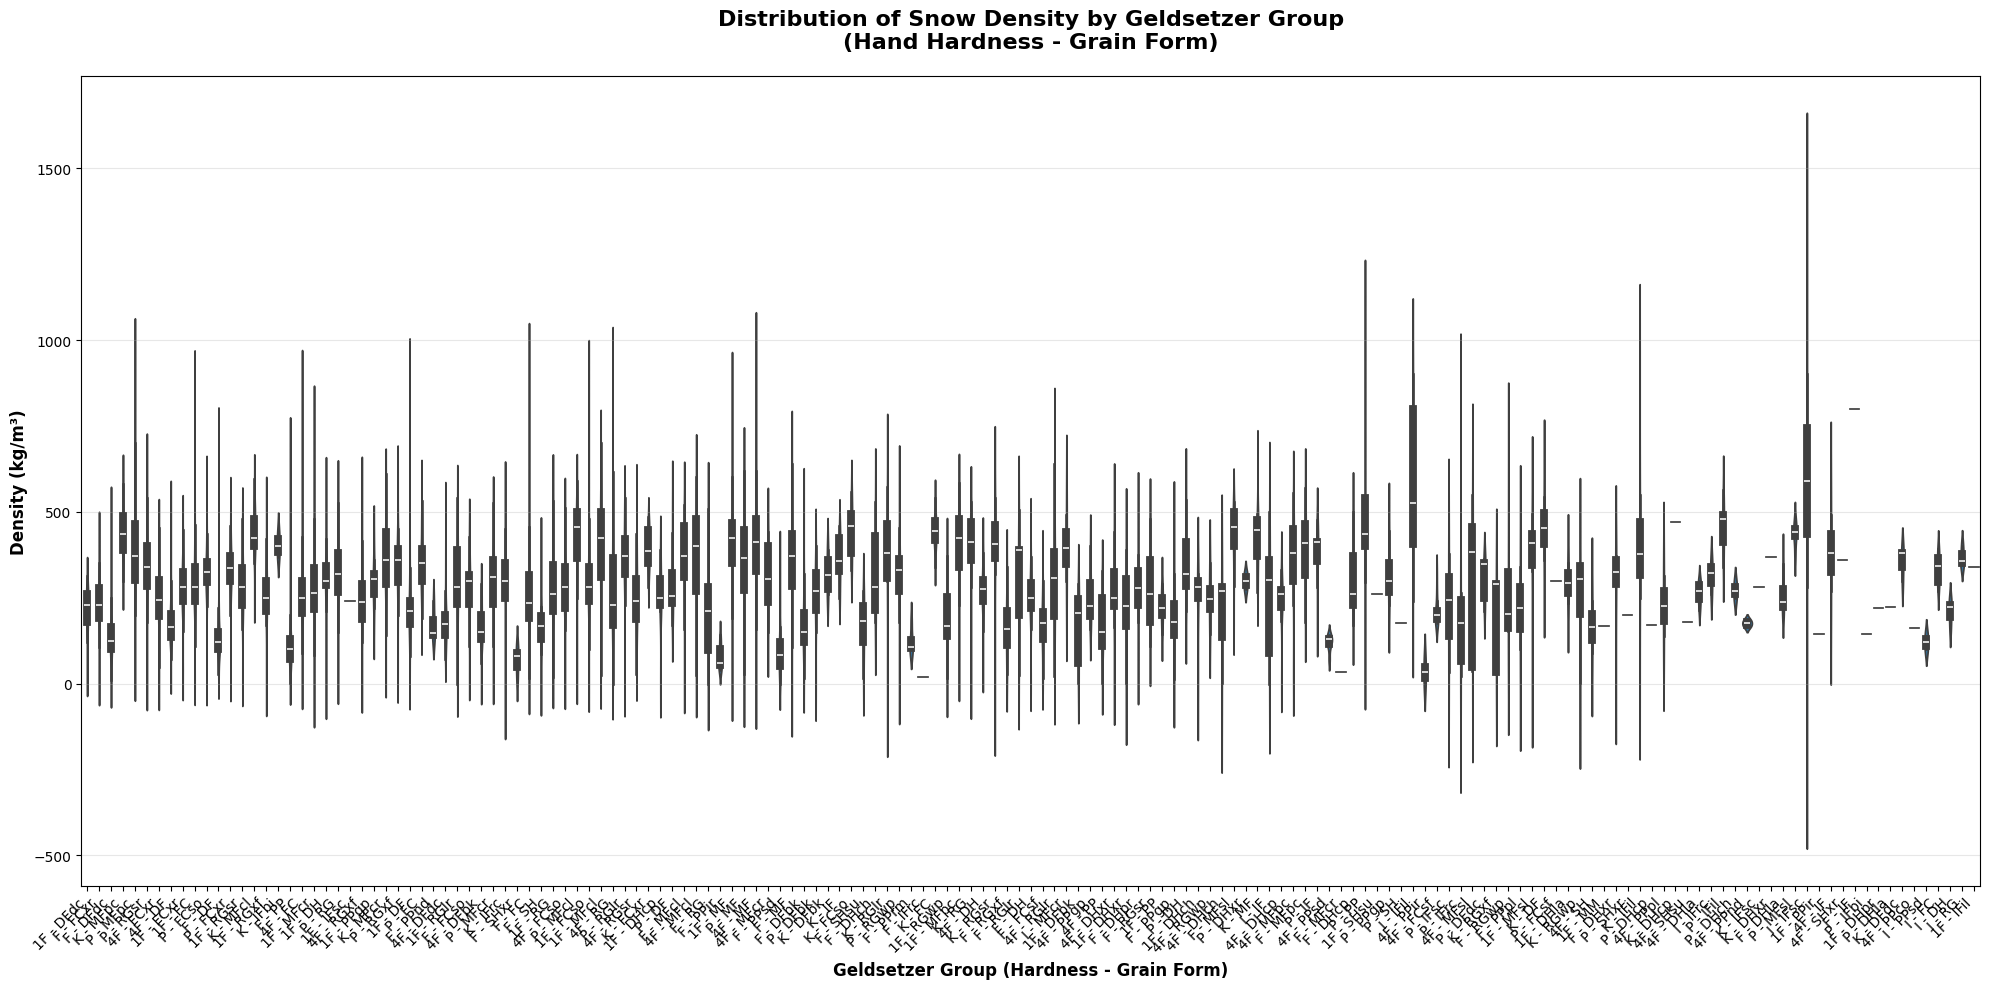

In [57]:
# Create violin plots of density for each geldsetzer_group
plt.figure(figsize=(20, 10))

# Filter out any rows with missing density or geldsetzer_group data
plot_data = geldsetzer_info_df.dropna(subset=['density', 'geldsetzer_group'])

# Create the violin plot
sns.violinplot(data=plot_data, x='geldsetzer_group', y='density', inner='box')

# Customize the plot
plt.title('Distribution of Snow Density by Geldsetzer Group\n(Hand Hardness - Grain Form)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Geldsetzer Group (Hardness - Grain Form)', fontsize=12, fontweight='bold')
plt.ylabel('Density (kg/m³)', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, alpha=0.3, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show statistics
print(f"Total observations: {len(plot_data):,}")
print(f"Number of unique geldsetzer groups: {plot_data['geldsetzer_group'].nunique()}")
print(f"\nDensity statistics by group:")
print(plot_data.groupby('geldsetzer_group')['density'].agg(['count', 'mean', 'std', 'min', 'max']).round(1))

plt.show()
